# MLops Project


### Experiment  and model tracking
Part of the  mlops course - [project](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/07-project/README.md)

This project aims to forecast France's energy consumption using time serie modeling. That is the notebook use for experiments. 


### Data Sources
- **RTE (Réseau de Transport d'Électricité)**: The primary source for energy consumption data in France. To access the data, you need to create an account.
  - [RTE Data Access](https://www.services-rte.com/en/download-data-published-by-rte.html?category=consumption&type=energy_consumption)

---


In [1]:
#Dependencies to install
#! pip install --upgrade pip
#! pip install  numpy requests-cache retry-requests  pandas skforecast xlrd matplotlib mlflow

### DATA PREPARTION

In [3]:
import pandas  as pd
import datetime
now = datetime.datetime.now().strftime('%d-%m-%Y%_H:%M:%S')

data_in_cloud={"2023": "https://docs.google.com/spreadsheets/d/1-pHLaQH9789x7dNs4EqnY3ZDoVV-VPNX/edit?usp=sharing&ouid=114251832052082604585&rtpof=true&sd=true",
               '2022': 'https://docs.google.com/spreadsheets/d/1-TYSdQbF3PnlXVxkLqbEaBbXFa3nBnKs/edit?usp=sharing&ouid=114251832052082604585&rtpof=true&sd=true'
               }


input_data=None
years=[2022,2023]

def get_input_data( year: int):
  daily_cons = pd.read_excel(f'https://github.com/remitoudic/mlops/raw/main/project/data%20/consumption/daily_{year}.xls', skiprows=17,  usecols=lambda x: x if not x.startswith('Unnamed') else None)
  daily_cons.dropna(inplace=True)
  daily_cons.reset_index(inplace=True,drop=True)
  daily_cons.drop(['Type de données'],inplace=True, axis=1)
  daily_cons.rename(columns={'Energie journalière (MWh)': "MWH"},inplace=True)
  daily_cons.rename(columns={'Date': "date"},inplace=True)
  daily_cons['date'] = pd.to_datetime(daily_cons['date'], format="%d/%m/%Y", errors='coerce')
  return daily_cons

def data_preparation(years:list):
  all_years=None
  for year in years:
    this_year = get_input_data(year)
    assert this_year.shape[0]== 365, f"Data issue => not 365 days in yer {year}"
    all_years=  pd.concat([all_years, this_year])

  all_years.set_index('date', inplace = True)
  all_years.sort_index(inplace = True)
  all_years = all_years.asfreq('D', method = 'bfill')
  return all_years


input_data = data_preparation(years)
assert int(input_data.shape[0]/len(years))==365
input_data

get_input_data(2022)


,date,MWH
0,2022-01-01,1209642.0
1,2022-01-02,1257035.0
2,2022-01-03,1430494.0
3,2022-01-04,1494954.0
4,2022-01-05,1643559.0
...,...,...
360,2022-12-27,1286380.0
361,2022-12-28,1292956.0
362,2022-12-29,1256168.0
363,2022-12-30,1255385.0


Train dates : 2022-01-01 00:00:00 --- 2023-12-01 00:00:00  (n=700)
Test dates  : 2023-12-02 00:00:00 --- 2023-12-31 00:00:00  (n=30)


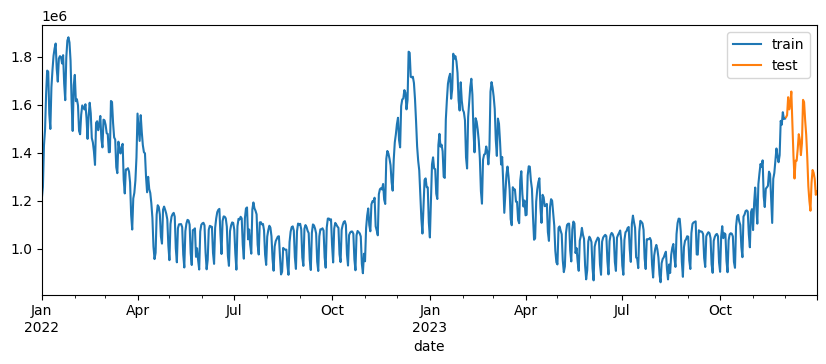

In [4]:
import matplotlib.pyplot as plt
# Split train-test
# ==============================================================================
steps = 30
data_train = input_data[:-steps]
data_test  = input_data[-steps:]

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(10, 3.5))
data_train['MWH'].plot(ax=ax, label='train')
data_test['MWH'].plot(ax=ax, label='test')
ax.legend()



In [20]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("MLOP_project")
mlflow.start_run()

<ActiveRun: >

### MODELING 1:    RandomForestRegressor

In [22]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import  joblib
with mlflow.active_run():
    mlflow.set_tag("developer", "Remi")
    lags_= 2
    mlflow.log_param('lags',lags_ )
    mlflow.autolog()
    # Create and train forecaster
    # ==============================================================================
    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=10),
                    lags      = lags_
                 )
    forecaster.fit(y=data_train['MWH'])
   
    # Predictions
    # ==============================================================================
    steps = 30
    predictions = forecaster.predict(steps=steps)
    predictions.head(7)

    # Test error
    # ==============================================================================
    error_mse = mean_squared_error(
                    y_true = data_test['MWH'],
                    y_pred = predictions
                )
    print(f"Test error (MSE): {error_mse}")
    mlflow.log_metric("error_mse", error_mse)
    #joblib.dump(forecaster, f'models/RandomForestRegressor_model_{now}.pkl')
    # Log the sklearn model and register as version 1
    #mlflow.sklearn.log_model(sk_model=forecaster,artifact_path="sklearn-model", registered_model_name=f"RandomForestRegressor_model")

AttributeError: __enter__

In [23]:
from skforecast.model_selection import grid_search_forecaster

# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5, 10]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['MWH'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/30 08:53:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0aed915e5fbd4cbf9df6ae4e1826a1ee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/07/30 08:54:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b558011e1bd54cde987ffdc19bd31937', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/07/30 08:54:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '587b61c222e64f468a33f28c7752e8a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/07/30 08:54:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '832d84ccafc54c958e862c2ccc4f56ce', which will track hyperparameters, performance metrics, model artifacts, and lineage i

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 34249043628.75192



In [24]:
results_grid
#best params
results_grid.iloc[11]

lags                         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lags_label                   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params                {'max_depth': 10, 'n_estimators': 100}
mean_squared_error                        42000003601.309837
max_depth                                                 10
n_estimators                                             100
Name: 4, dtype: object

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Remi")
    # Create and train forecaster with the best hyperparameters 
    # ==============================================================================
    regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=123)
    forecaster = ForecasterAutoreg(
                     regressor = regressor,
                     lags      = 7
                 )
    forecaster.fit(y=data_train['MWH'])
    # Predictions best model
    # ==============================================================================
    predictions = forecaster.predict(steps=steps)
    
    mlflow.log_metric("error_mse", error_mse)
    joblib.dump(forecaster, f'models/RandomForestRegressor_model_{now}.pkl')
    
    # Log the sklearn model and register the best model
    mlflow.sklearn.log_model(sk_model=forecaster,artifact_path="sklearn-model",registered_model_name=f"RandomForestRegressor_model")
    

Registered model 'RandomForestRegressor_model' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForestRegressor_model'.
2024/07/30 08:55:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


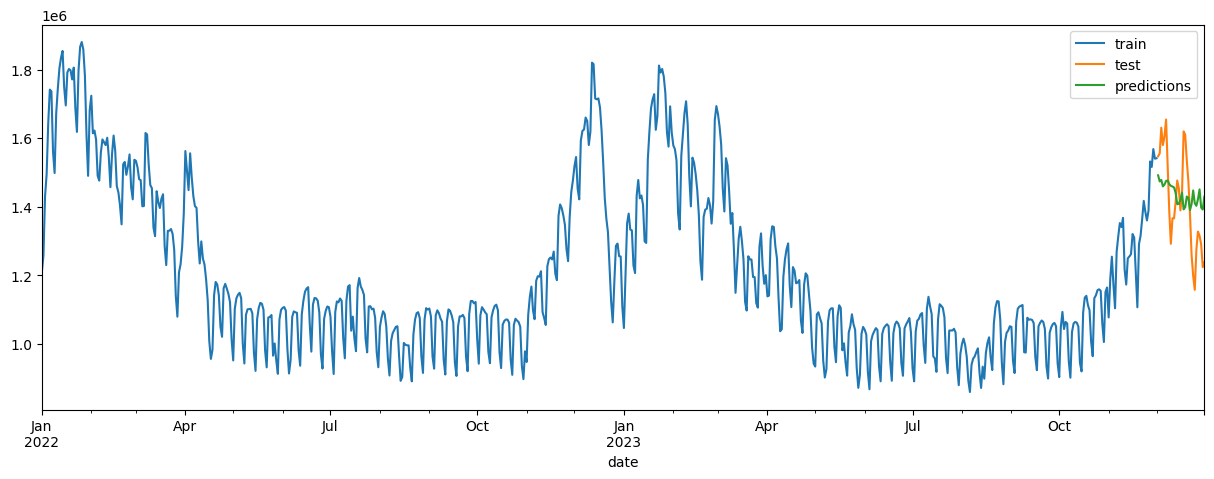

In [26]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
data_train['MWH'].plot(ax=ax, label='train')
data_test['MWH'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

### MODELING 2:   GradientBoostingRegressor

In [10]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import  GradientBoostingRegressor
import  joblib
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=10),
                lags      = 6
             )
forecaster.fit(y=data_train['MWH'])
joblib.dump(forecaster, 'models/forecaster_model.pkl')

2024/07/30 08:49:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '16be6a1352254eb7996627e9ca5074c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


['models/forecaster_model.pkl']

In [11]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import GradientBoostingRegressor


with mlflow.start_run():
    mlflow.set_tag("developer", "Remi")
    lags_= 2
    mlflow.log_param('lags',lags_ )
    mlflow.autolog()

    # Hyperparameters: grid search
    # ==============================================================================
    steps = 30
    forecaster = ForecasterAutoreg(
                     regressor = GradientBoostingRegressor(random_state=123),
                     lags      = 12 # This value will be replaced in the grid search
                 )

    # Candidate values for lags
    lags_grid = [10, 20]
    
    # Candidate values for regressor's hyperparameters
    param_grid = {
        'n_estimators': [100, 250],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data_train['MWH'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = steps,
                       refit              = False,
                       metric             = 'mean_squared_error',
                       initial_train_size = int(len(data_train)*0.5),
                       fixed_train_size   = False,
                       return_best        = True,
                       n_jobs             = 'auto',
                       verbose            = False
                   )

2024/07/30 08:49:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Number of models compared: 48.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/24 [00:00<?, ?it/s]

2024/07/30 08:49:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3f038bc6f57b41a1baef527212173cbb. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'subsample\', \'old_value\': \'0.8\', \'new_value\': \'1.0\'}]\' for run ID=\'3f038bc6f57b41a1baef527212173cbb\'.")]')]
2024/07/30 08:49:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3f038bc6f57b41a1baef527212173cbb. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'n_estimators\', \'old_value

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250, 'subsample': 1.0}
  Backtesting metric: 19064514337.716393



In [15]:
results_grid
results_grid.iloc[35]

lags                                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lags_label                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params                {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
mean_squared_error                                   45607008294.284142
learning_rate                                                      0.01
max_depth                                                           5.0
n_estimators                                                      250.0
subsample                                                           1.0
Name: 7, dtype: object

In [16]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


with mlflow.start_run():
    mlflow.set_tag("developer", "Remi")
    mlflow.set_tag("best model", "Remi")
    mlflow.autolog()
    # Create and train forecaster with the best hyperparameters 
    # ==============================================================================
    regressor = GradientBoostingRegressor(n_estimators=250,
                                          max_depth=5,
                                          learning_rate=0.1,
                                          subsample=1.0,
                                          random_state=123)

    # Create and train forecaster with the best hyperparameters and lags found
    forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 10
             )
    forecaster.fit(y=data_train['MWH'])

    # Predictions best model
    # ==============================================================================
    steps = 30
    predictions = forecaster.predict(steps=steps)

    
    # Test error
    # ==============================================================================
    error_mse = mean_squared_error(
                    y_true = data_test['MWH'],
                    y_pred = predictions
                )
    print(f"Test error (MSE): {error_mse}")
    
    mlflow.log_metric("error_mse", error_mse)
    joblib.dump(forecaster, f'models/GradientBoostingRegressor{now}.pkl')
    
    # Log the sklearn model and register the best model
    mlflow.sklearn.log_model(sk_model=forecaster,artifact_path="sklearn-model",registered_model_name=f"GradientBoostingRegressor_model")
    




2024/07/30 08:52:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Test error (MSE): 17773442796.942036


Registered model 'GradientBoostingRegressor_model' already exists. Creating a new version of this model...
Created version '2' of model 'GradientBoostingRegressor_model'.
2024/07/30 08:52:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


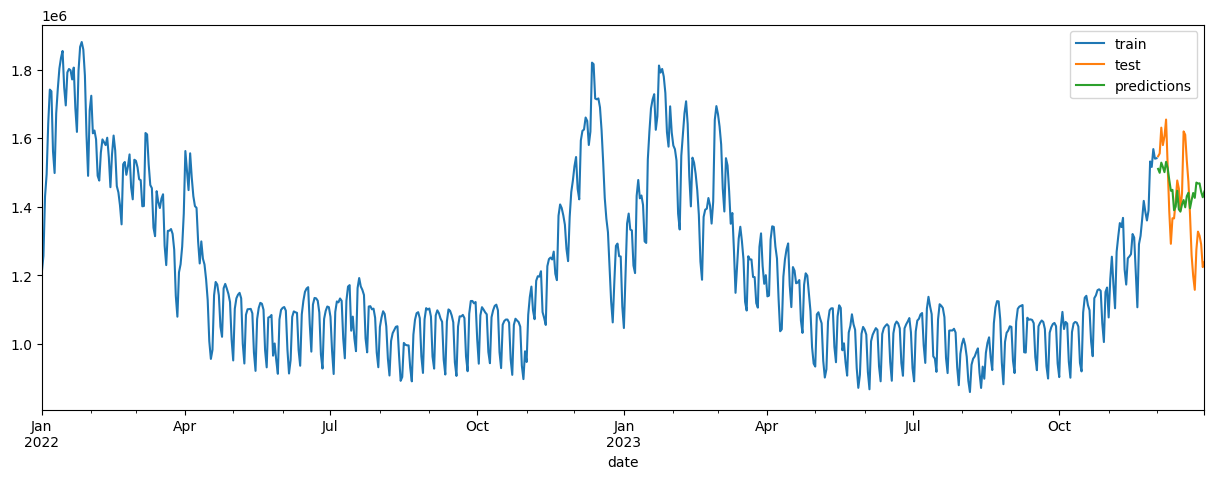

In [17]:
    # Plot predictions versus test data
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(15, 5))
    data_train['MWH'].plot(ax=ax, label='train')
    data_test['MWH'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()
    plt.show()